In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 51kB 60.2MB/s eta 0:00:01
     |████████████████████████████████| 317kB 58.4MB/s eta 0:00:01
     |████████████████████████████████| 51kB 58.3MB/s eta 0:00:01
  Found existing installation: Keras-Applications 1.0.2
    Uninstalling Keras-Applications-1.0.2:
      Successfully uninstalled Keras-Applications-1.0.2
  Found existing installation: Keras-Preprocessing 1.0.1
    Uninstalling Keras-Preprocessing-1.0.1:
      Successfully uninstalled Keras-Preprocessing-1.0.1
  Found existing installation: Keras 2.2.0
    Uninstalling Keras-2.2.0:
      Successfully uninstalled Keras-2.2.0
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
if os.path.exists('./data') == False:
    from modelarts.session import Session
    session = Session()

    session.download_data(
        bucket_path="modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz",
        path="./dog_and_cat_25000.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./dog_and_cat_25000.tar.gz

    # 清理压缩包
    !rm -f ./dog_and_cat_25000.tar.gz

Successfully download file modelarts-labs/end2end/image_recognition/dog_and_cat_25000.tar.gz from OBS to local ./dog_and_cat_25000.tar.gz


In [3]:
!mkdir model

from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
import numpy as np

from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [38]:
import os
from PIL import Image
def load_data():
    dirname = "./data"
    path = "./data"

    num_train_samples = 25000

    x_train = np.empty((num_train_samples, 224,224,3), dtype='uint8')
    y_train = np.empty((num_train_samples,1), dtype='uint8')
    index = 0
    for file in os.listdir("./data"):
        image = Image.open(os.path.join(dirname,file)).resize((224,224))
        image = np.array(image)
        x_train[index,:,:,:] = image

        if "cat" in file:
            y_train[index,0] =1
        elif "dog" in file:
            y_train[index,0] =0

        index += 1
    return (x_train, y_train)

(x_train, y_train) = load_data()
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 1)


In [39]:
from keras.utils import np_utils
def process_data(x_train,y_train):
    x_train = x_train.astype(np.float32)
    x_train /= 255
    n_classes = 2
    y_train = np_utils.to_categorical(y_train, n_classes)
    return x_train,y_train

x_train,y_train= process_data(x_train,y_train)
print(x_train.shape)
print(y_train.shape)

(25000, 224, 224, 3)
(25000, 2)


In [48]:
def build_model(base_model):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    print(type(model))
    return model

base_model = VGG16(weights=None, include_top=False)


In [49]:
model = build_model(base_model)

<class 'keras.engine.training.Model'>


In [50]:
lr_base = 0.0001
epochs = 50
lr_power = 0.9

import keras 
opt = keras.optimizers.adadelta(lr=lr_base, decay=1e-6)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [51]:
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=5, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)

lr_reducer  = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=3, verbose=1, mode="auto", min_lr=0)


def step_decay(epoch,lr=lr_base):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate


def lr_scheduler(epoch, mode='power_decay'):
    '''if lr_dict.has_key(epoch):
        lr = lr_dict[epoch]
        print 'lr: %f' % lr'''

    if mode is 'power_decay':
        # original lr scheduler
        lr = lr_base * ((1 - float(epoch) / epochs) ** lr_power)
    if mode is 'exp_decay':
        # exponential decay
        lr = (float(lr_base) ** float(lr_power)) ** float(epoch + 1)
    # adam default lr
    if mode is 'adam':
        lr = 0.001

    if mode is 'progressive_drops':
        # drops as progression proceeds, good for sgd
        if epoch > 0.9 * epochs:
            lr = 0.0001
        elif epoch > 0.75 * epochs:
            lr = 0.001
        elif epoch > 0.5 * epochs:
            lr = 0.01
        else:
            lr = 0.1

    print('lr: %f' % lr)
    return lr

lr_scheduler = LearningRateScheduler(step_decay)

callbacks = [es,cp,lr_reducer,lr_scheduler]

In [52]:
history = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=epochs, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/50
18750/18750 [==============================] - 172s 9ms/step - loss: 0.6929 - acc: 0.5105 - val_loss: 0.6926 - val_acc: 0.5072

Epoch 00001: val_acc improved from -inf to 0.50720, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/50
18750/18750 [==============================] - 168s 9ms/step - loss: 0.6916 - acc: 0.5397 - val_loss: 0.6930 - val_acc: 0.4933

Epoch 00002: val_acc did not improve from 0.50720
Epoch 3/50
18750/18750 [==============================] - 168s 9ms/step - loss: 0.6824 - acc: 0.5659 - val_loss: 0.6638 - val_acc: 0.6104

Epoch 00003: val_acc improved from 0.50720 to 0.61040, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 4/50
18750/18750 [==============================] - 167s 9ms/step - loss: 0.6605 - acc: 0.5962 - val_loss: 0.6504 - val_acc: 0.6131

Epoch 00004: val_acc improved from 0.61040 to 0.61312, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 5/50
18750/18750 [============

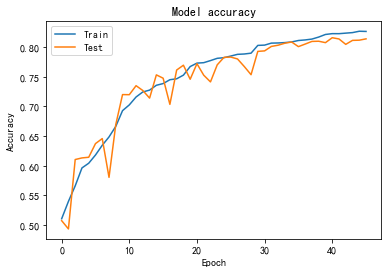

In [53]:
import matplotlib.pyplot as plt

# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

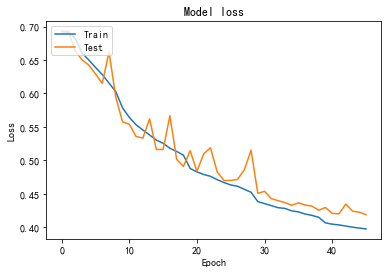

In [54]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [55]:
es = EarlyStopping(monitor='val_acc', min_delta=0.001, patience=2, verbose=1, mode='auto')
cp = ModelCheckpoint(filepath="./model/ckp_vgg16_dog_and_cat.h5", monitor="val_acc", verbose=1, save_best_only=True, mode="auto", period=1)
lr = ReduceLROnPlateau(monitor="val_acc", factor=0.1, patience=3, verbose=1, mode="auto", min_lr=0)
callbacks = [es,cp,lr]

In [56]:
history_steps_15 = model.fit(x=x_train, 
                  y=y_train, 
                  batch_size=16, 
                  epochs=20, 
                  verbose=1, 
                  callbacks=callbacks, 
                  validation_split=0.25, 
                  shuffle=True, 
                  initial_epoch=0, 
                 )

Train on 18750 samples, validate on 6250 samples
Epoch 1/20
18750/18750 [==============================] - 169s 9ms/step - loss: 0.3956 - acc: 0.8274 - val_loss: 0.4130 - val_acc: 0.8202

Epoch 00001: val_acc improved from -inf to 0.82016, saving model to ./model/ckp_vgg16_dog_and_cat.h5
Epoch 2/20
18750/18750 [==============================] - 168s 9ms/step - loss: 0.3945 - acc: 0.8278 - val_loss: 0.4129 - val_acc: 0.8198

Epoch 00002: val_acc did not improve from 0.82016
Epoch 3/20
18750/18750 [==============================] - 167s 9ms/step - loss: 0.3930 - acc: 0.8284 - val_loss: 0.4317 - val_acc: 0.8026

Epoch 00003: val_acc did not improve from 0.82016
Epoch 00003: early stopping


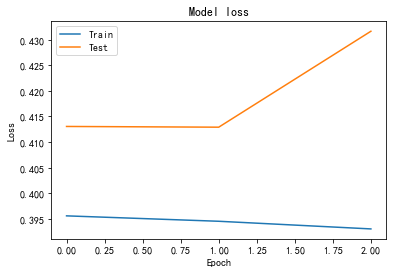

In [57]:
# 绘制训练 & 验证的损失值
plt.plot(history_steps_15.history['loss'])
plt.plot(history_steps_15.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

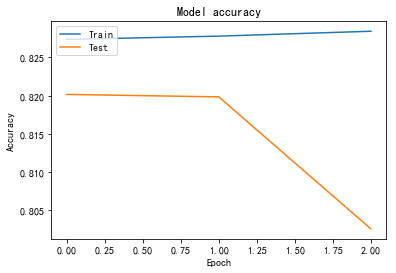

In [58]:
# 绘制训练 & 验证的准确率值
plt.plot(history_steps_15.history['acc'])
plt.plot(history_steps_15.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()